# Interactive Geometry Remeshing

A Python implementation of Pierre Alliez, Mark Meyer, and Mathieu Desbrun's research paper "Interactive Geometry Remeshing."

Link to google drive with demo video: https://drive.google.com/drive/folders/1yvPP3hPceYbScddZL6QRBsEnUGWdBCpy?usp=drive_link


## Dependencies

All geometry processing is done with NumPy and igl, I did have to use VisPy and Pillow (PIL)or handling some image processing, although neither are used for any built-in mesh/geometry algorithms. In order to run VisPy in a Jupyter notebook you also need 
 
```conda install -c conda-forge vispy``` 

or

```pip install --upgrade vispy```

and

 ```c```


In [1]:
pip install --upgrade vispy

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [3]:
import math
import random
import os

import igl
import numpy as np
import meshplot as mp
import scipy as sp
import ipywidgets as iw

import vispy
from vispy import io
from vispy import app, gloo
from vispy.gloo import Program
from PIL import Image

## Defining Feature Edges With Dihedral Angle Thresholding

Extract mesh "features" which we will try to preserve throughout the remeshing.


In [4]:
def feature_edges(v,f,threshold):
    edge_faces = []

    dihedral_threshold = threshold/180 * np.pi
    f_normals = igl.per_face_normals(v,f,np.ndarray([0,0]))
    edge_flaps = igl.edge_flaps(f)
    edges = edge_flaps[0]
    
    threshold_edges = []
    for i in range(edges.shape[0]):
        # find normals of faces connecting edge
        edge_face_norms = f_normals[edge_flaps[2][i]]

        # find dihedral angle between edge faces
        f1n = edge_face_norms[0] / np.linalg.norm(edge_face_norms[0])
        f2n = edge_face_norms[1] / np.linalg.norm(edge_face_norms[1])
        dihedral_angle = np.arccos(np.clip(np.dot(f1n, f2n), -1.0, 1.0))

        # add angles greater than threshold to list
        if dihedral_angle > dihedral_threshold or (-1 in edge_flaps[2][i]):
            threshold_edges.append(edges[i])
            
            # add edge faces to list
            if edge_flaps[2][i][0] != -1:
                edge_faces.append(edge_flaps[2][i][0])
            if edge_flaps[2][i][1] != -1:
                edge_faces.append(edge_flaps[2][i][1])

    threshold_edges = np.array(threshold_edges)
    return threshold_edges, edge_faces



v, f = igl.read_triangle_mesh("data/camel_head.off")
feature_edge_list, edge_faces = feature_edges(v,f,20)

col = np.ones_like(f)
col[edge_faces, 1:] = 0

p = mp.plot(v, f, c=col, shading={"wireframe": 0})
p.add_lines(v[feature_edge_list][:,0], v[feature_edge_list][:,1], shading={"line_color": "yellow"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.9967555…

1

## Parametrization onto Square Map

In [5]:
def circle_to_square(x_circ,y_circ):
    x = 0.5 * np.sqrt( 2 + x_circ**2 - y_circ**2 + 2*x_circ*np.sqrt(2) ) - 0.5 * np.sqrt( 2 + x_circ**2 - y_circ**2 - 2*x_circ*np.sqrt(2) )
    y = 0.5 * np.sqrt( 2 - x_circ**2 + y_circ**2 + 2*y_circ*np.sqrt(2) ) - 0.5 * np.sqrt( 2 - x_circ**2 + y_circ**2 - 2*y_circ*np.sqrt(2) )
    x = round(max(min(1,x),-1),5)
    y = round(max(min(1,y),-1),5)
    return [x,y]

def parametrize(v,f):
    ## Find the open boundary
    bnd = igl.boundary_loop(f)
    
    ## Map the boundary to a circle, preserving edge proportions
    bnd_uv = igl.map_vertices_to_circle(v, bnd)
    
    # remap circle boundary onto square
    bnd_uv = np.array([circle_to_square(x_circ,y_circ) for [x_circ,y_circ] in bnd_uv])

    # force points into corners
    TL = np.array([-1,1])
    TR = np.array([1,1])
    BL = np.array([-1,-1])
    BR = np.array([1,-1])
    bndTL = 0
    bndTR = 0
    bndBL = 0
    bndBR = 0
    for coordi, coord in enumerate(bnd_uv):
        if np.linalg.norm(coord-TL) < np.linalg.norm(bnd_uv[bndTL]-TL):
            bndTL = coordi
        if np.linalg.norm(coord-TR) < np.linalg.norm(bnd_uv[bndTR]-TR):
            bndTR = coordi
        if np.linalg.norm(coord-BL) < np.linalg.norm(bnd_uv[bndBL]-BL):
            bndBL = coordi
        if np.linalg.norm(coord-BR) < np.linalg.norm(bnd_uv[bndBR]-BR):
            bndBR = coordi

    bnd_uv[bndTL] = TL
    bnd_uv[bndTR] = TR
    bnd_uv[bndBL] = BL
    bnd_uv[bndBR] = BR
    
    ## Harmonic parametrization for the internal vertices
    return igl.harmonic(v, f, bnd, bnd_uv, 1)

v, f = igl.read_triangle_mesh("data/camel_head.off")
uv = parametrize(v,f)
feature_edge_list, _ = feature_edges(v,f,20)


p = mp.plot(v, f, c=np.ones_like(f), shading={"wireframe": False})
p.add_lines(v[feature_edge_list][:,0], v[feature_edge_list][:,1], shading={"line_color": "yellow"})
@iw.interact(mode=['2D','3D'])
def switch(mode):
    if mode == "3D":
        mp.plot(v, f, c=uv[:,0],shading={"wireframe": 0}, plot=p)
        p.add_lines(v[feature_edge_list][:,0], v[feature_edge_list][:,1], shading={"line_color": "yellow"})
        
    if mode == "2D":
        mp.plot(uv, f, c=uv[:,0], shading={"wireframe": 1, "line_width":0.2}, plot=p)
        p.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "yellow"})
        p.add_points(uv, shading={"point_size": .04})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.9967555…

interactive(children=(Dropdown(description='mode', options=('2D', '3D'), value='2D'), Output()), _dom_classes=…

## Geometry Maps

- Using the chosen paramterization, generate an atlas of geometry maps containing useful data pertaining to the input mesh.
- The area distortion and curvature maps will be used to generate a control map which determines the densities of resamplings on the parameterization. (Allows user to control how vertices are distributed across remesh).
- The embedding and face index maps can be used to convert the 2D remesh back into 3D. (allows for quick lookups of xyz coordinates based on uv coordinates)
- Additional maps (normal, colour, texture) can be generated if we wish for our remesh to contain any such attributes.

### 1. Area Distortion Map

In [6]:
def normalizeZeroToOne(arr):
    if(min(arr) < 0):
        arr -= min(arr)
    return (1/max(arr)) * arr
    
def areaDistortion(v,uv,f):
    a3d = igl.doublearea(v,f)
    a2d = igl.doublearea(uv,f)

    VF, NI = igl.vertex_triangle_adjacency(f,v.shape[0])
    face_area_distortion = a3d/a2d

    vert_area_distortion = np.zeros_like(v[:,0])
    for i in range(v.shape[0]):
        face0 = NI[i]
        facen = NI[i+1]
        faces = VF[face0:facen]
        faceAreas = a3d[faces]
        faceAreas = (1/np.sum(faceAreas)) * faceAreas
        #print(i, faces,faceAreas)

        vertAD = 0
        for facei, face in enumerate(faces):
            vertAD += face_area_distortion[face] * faceAreas[facei]
        vert_area_distortion[i] = vertAD

    return normalizeZeroToOne(vert_area_distortion)


v, f = igl.read_triangle_mesh("data/camel_head.off")
uv = parametrize(v,f)
feature_edge_list, _ = feature_edges(v,f,10)
area_distortion = areaDistortion(v,uv,f)

a = mp.plot(uv, f, c=area_distortion, shading={"wireframe": 0, "line_width":0.2})
a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
a.add_points(uv, shading={"point_size": .03, "point_color": "black"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

2

### 2. Curvature Maps

In [7]:
def curveMaps(v,f):
    gaussCurv = igl.gaussian_curvature(v,f)
    _, _, maxCurv, minCurv = igl.principal_curvature(v, f)
    totalCurv = maxCurv * maxCurv + minCurv * minCurv

    gaussCurv = normalizeZeroToOne(gaussCurv * gaussCurv)
    maxCurv = normalizeZeroToOne(maxCurv)
    minCurv = normalizeZeroToOne(minCurv)
    totalCurv = normalizeZeroToOne(totalCurv)

    return gaussCurv, maxCurv, minCurv, totalCurv


v, f = igl.read_triangle_mesh("data/camel_head.off")
uv = parametrize(v,f)
feature_edge_list, _ = feature_edges(v,f,10)
gaussCurv, maxCurv, minCurv, totalCurv = curveMaps(v,f)

a = mp.plot(uv, f, c=gaussCurv, shading={"wireframe": 0, "line_width":0.2})
a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
@iw.interact(mode=['Gaussian','Max','Min','Total'])
def switch(mode):
    if mode == "Gaussian":
        mp.plot(uv, f, c=gaussCurv, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
        
    if mode == "Max":
        mp.plot(uv, f, c=maxCurv, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
        
    if mode == "Min":
        mp.plot(uv, f, c=minCurv, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
        
    if mode == "Total":
        mp.plot(uv, f, c=totalCurv, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

interactive(children=(Dropdown(description='mode', options=('Gaussian', 'Max', 'Min', 'Total'), value='Gaussia…

### 3. Embedding Map

In [8]:
def scalarToRGB(scalarMap):
    rgbMap = []
    for i in range(scalarMap.shape[0]):
        r = min(1/3,scalarMap[i])
 
        g = min(max(0,(scalarMap[i]-1/3)),1/3)
 
        b = min(max(0,(scalarMap[i]-2/3)),1/3)
            
        rgbMap.append([r,g,b])
    return np.array(rgbMap)

def embeddingMaps(v):
    xMap = v[:,0].copy()
    yMap = v[:,1].copy()
    zMap = v[:,2].copy()
    xMap = normalizeZeroToOne(xMap)
    yMap = normalizeZeroToOne(yMap)
    zMap = normalizeZeroToOne(zMap)
    
    return scalarToRGB(xMap), scalarToRGB(yMap), scalarToRGB(zMap)


v, f = igl.read_triangle_mesh("data/camel_head.off")
uv = parametrize(v,f)
feature_edge_list, _ = feature_edges(v,f,10)
xMap, yMap, zMap = embeddingMaps(v)

a = mp.plot(uv, f, c=v, shading={"wireframe": 0, "line_width":0.2})
a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
@iw.interact(mode=['Vertex Position','xMap','yMap','zMap'])
def switch(mode):
    if mode == "Vertex Position":
        mp.plot(uv, f, c=v, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
        
    if mode == "xMap":
        mp.plot(uv, f, c=xMap, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
        
    if mode == "yMap":
        mp.plot(uv, f, c=yMap, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})
        
    if mode == "zMap":
        mp.plot(uv, f, c=zMap, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
        a.add_points(uv, shading={"point_size": .03, "point_color": "black"})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

interactive(children=(Dropdown(description='mode', options=('Vertex Position', 'xMap', 'yMap', 'zMap'), value=…

### 4. Face Index Map

In [9]:
def indexMap(v,f):
    face_index_list = []
    face_index_map = {}
    
    for i in range(f.shape[0]):
        face_col = [int(random.uniform(0,255)),int(random.uniform(0,255)),int(random.uniform(0,255))]
        face_index_list.append(face_col)
        while str(face_index_list[i]) in face_index_map:
            face_index_list[i] = [int(random.uniform(0,255)),int(random.uniform(0,255)),int(random.uniform(0,255))]
        face_index_map[str(face_index_list[i])] = i
        
    face_index_list = np.array(face_index_list)
    return face_index_list, face_index_map


random.seed(1)
v, f = igl.read_triangle_mesh("data/camel_head.off")
uv = parametrize(v,f)
feature_edge_list, _ = feature_edges(v,f,10)
face_index_list, face_index_map = indexMap(v,f)

face_index_list = (1/255) * face_index_list

a = mp.plot(uv, f, c=face_index_list, shading={"wireframe": 0, "line_width":0.2})
a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
a.add_points(uv, shading={"point_size": .03, "point_color": "black"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

2

### 5. (optional) Additional Maps

ex: normal, texture, color

Useful if the remeshed model needs these attributes added after remeshing, not needed for remeshing process itself.

In [10]:
v, f = igl.read_triangle_mesh("data/camel_head.off")
uv = parametrize(v,f)
feature_edge_list, _ = feature_edges(v,f,10)

v_p = np.hstack([uv, np.zeros((uv.shape[0],1))])
pvn = igl.per_vertex_normals(v,f)

a = mp.plot(uv, f, c=pvn, shading={"wireframe": 0, "line_width":0.2})
a.add_lines(uv[feature_edge_list][:,0], uv[feature_edge_list][:,1], shading={"line_color": "black"})
a.add_points(uv, shading={"point_size": .03, "point_color": "black"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

2

## Combining Maps to Create Control Map (User-Controlled)

In [11]:
def designControlMap(v,f):
    uv = parametrize(v,f)
    feature_edge_list, _ = feature_edges(v,f,10)
    
    area_distortion = areaDistortion(v,uv,f)
    gaussCurv, maxCurv, minCurv, totalCurv = curveMaps(v,f)

    areaDistortionFactor = 0.5
    gaussCurvFactor = 0.5
    maxCurvFactor = 0.5
    minCurvFactor = 0.5
    totalCurvFactor = 0.5
    
    controlMap =  areaDistortionFactor * area_distortion + gaussCurvFactor * gaussCurv + maxCurvFactor * maxCurv + minCurvFactor * minCurv + totalCurvFactor * totalCurv
    controlMap = normalizeZeroToOne(controlMap)

    a = mp.plot(uv, f, c=controlMap, shading={"wireframe": 0, "line_width":0.2})
    @mp.interact(areaDistortionFactor = (0.0,1.0),gaussCurvFactor = (0.0,1.0),maxCurvFactor = (0.0,1.0),minCurvFactor = (0.0,1.0),totalCurvFactor = (0.0,1.0))
    def ff(areaDistortionFactor, gaussCurvFactor,maxCurvFactor,minCurvFactor,totalCurvFactor):
        controlMap =  areaDistortionFactor * area_distortion + gaussCurvFactor * gaussCurv + maxCurvFactor * maxCurv + minCurvFactor * minCurv + totalCurvFactor * totalCurv
        controlMap = normalizeZeroToOne(controlMap)
        mp.plot(uv, f, c=controlMap, shading={"wireframe": 0, "line_width":0.2}, plot=a)
        print("Control Map Parameters:")
        print(areaDistortionFactor,",",gaussCurvFactor,",",maxCurvFactor,",",minCurvFactor,",",totalCurvFactor)

v, f = igl.read_triangle_mesh("data/camel_head.off")

feature_edge_list, _ = feature_edges(v,f,10)
xMap, yMap, zMap = embeddingMaps(v)
uv = parametrize(v,f)
designControlMap(v,f)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

interactive(children=(FloatSlider(value=0.5, description='areaDistortionFactor', max=1.0), FloatSlider(value=0…

## Save Control Map Based on User Preferences

Instructions:

1. Adjust control map parameters above to your preference. (For most meshes I would recommend only using the area distortion and total curvature)
2. Copy the parameters output at the bottom and paste them into the function call for ```createControlMap(v,f, <Control Map Parameters> )```

In [12]:
def createControlMap(v,f,
                     areaDistortionFactor,gaussCurvFactor,maxCurvFactor,minCurvFactor,totalCurvFactor
                    ):
    uv = parametrize(v,f)    
    area_distortion = areaDistortion(v,uv,f)
    gaussCurv, maxCurv, minCurv, totalCurv = curveMaps(v,f)
    controlMap =  areaDistortionFactor * area_distortion + gaussCurvFactor * gaussCurv + maxCurvFactor * maxCurv + minCurvFactor * minCurv + totalCurvFactor * totalCurv
    return normalizeZeroToOne(controlMap)

controlMap = createControlMap(v,f,
0.7 , 0.0 , 0.0 , 0.0 , 0.5
                             )
mp.plot(uv, f, c=controlMap, shading={"wireframe": 0, "line_width":0.2, "colormap": "Greys"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

## Generating Images of Maps with OpenGL

- For converting the igl generated scalar maps (which are just NumPy arrays containing vertex/face attributes) into images, I pack the maps into vertex buffers and pass them through an OpenGL shader.
- I found that there was some sort of conflict when running Meshplot and PyOpenGL in the same environment so I used the VisPy library for this step.
- This serves as a good demonstration of how this algorithm would be well-suited to real-time interactive remeshing; The research paper recommended using GPU-accelerated algorithms and by passing user controlled parameters as uniforms to an openGL shader the user could see a live preview of what their control map looks like. Compute shaders could be run on the maps to generate remeshes in real-time.

  Note: Make sure when running the following code blocks that you don't resize any of the renders before they've been exported as the export is based on the window size - If the maps are different sizes it causes issues.


In [13]:
def buildGLBuffers(uv,f,map):
    vertexBuffer = []
    colorBuffer = []
    if (map.shape[0] == uv.shape[0]):
        if (len(map.shape) > 1):
            for face in f:
                for vert in face:
                    vertexBuffer.append(tuple(uv[vert]))
                    colorBuffer.append((map[vert][0],map[vert][1],map[vert][2],0))
        else:
            for face in f:
                for vert in face:
                    vertexBuffer.append(tuple(uv[vert]))
                    colorBuffer.append((map[vert],map[vert],map[vert],0))
                
    if (map.shape[0] == f.shape[0]):
        if (len(map.shape) > 1):
            for facei, face in enumerate(f):
                for vert in face:
                    vertexBuffer.append(tuple(uv[vert]))
                    colorBuffer.append((map[facei][0],map[facei][1],map[facei][2],0))
                    
    return vertexBuffer, colorBuffer

In [14]:
class Canvas(app.Canvas):
    def __init__(self, size=128):
        super().__init__(size=(size, size))

        self.program = Program(vertex, fragment, len(vertexBuffer))
        self.program['color'] = colorBuffer
        self.program['position'] = vertexBuffer
        
        gloo.set_viewport(0, 0, *self.physical_size)

        self.show()

    def on_draw(self, event):
        gloo.clear()
        self.program.draw('triangles')

    def on_resize(self, event):
        gloo.set_viewport(0, 0, *event.physical_size)

mapSize = 128

In [15]:
pip install jupyter_rfb

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [17]:
pip install glfw

   ---------------------------------------- 0.0/493.9 kB ? eta -:--:--
   -- ------------------------------------- 30.7/493.9 kB 1.3 MB/s eta 0:00:01
   -------------------- ------------------- 256.0/493.9 kB 3.9 MB/s eta 0:00:01
   -------------------------------------- - 471.0/493.9 kB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 493.9/493.9 kB 3.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


RFBOutputContext()

CanvasBackend(css_height='128px', css_width='128px')
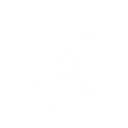

In [18]:
vertex = """
    attribute vec4 color;
    attribute vec2 position;
    varying vec4 v_color;
    void main()
    {
        gl_Position = vec4(position, 0.0, 1.0);
        v_color = vec4(1,1,1,1)-color;
    } """

fragment = """
    varying vec4 v_color;
    void main()
    {
        gl_FragColor = v_color;
    } """

vertexBuffer, colorBuffer =  buildGLBuffers(uv,f,controlMap)

c = Canvas(mapSize)
c

In [19]:
img=c.render('triangle_strip')
vispy.io.image.write_png("controlMap.png", img)

RFBOutputContext()

CanvasBackend(css_height='128px', css_width='128px')
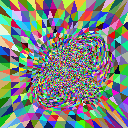

In [20]:
vertex = """
    attribute vec4 color;
    attribute vec2 position;
    varying vec4 v_color;
    void main()
    {
        gl_Position = vec4(position, 0.0, 1.0);
        v_color = vec4(color.rgb,1);
    } """

fragment = """
    varying vec4 v_color;
    void main()
    {
        gl_FragColor = v_color;
    } """

vertexBuffer, colorBuffer = buildGLBuffers(uv,f,face_index_list)

c = Canvas(mapSize)
c

In [21]:
img=c.render('triangle_strip')
vispy.io.image.write_png("faceIndexMap.png", img)

RFBOutputContext()

CanvasBackend(css_height='128px', css_width='128px')
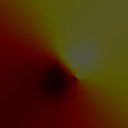

In [22]:
vertex = """
    attribute vec4 color;
    attribute vec2 position;
    varying vec4 v_color;
    void main()
    {
        gl_Position = vec4(position, 0.0, 1.0);
        v_color = vec4(color.rgb,1);
    } """

fragment = """
    varying vec4 v_color;
    void main()
    {
        gl_FragColor = v_color;
    } """

vertexBuffer, colorBuffer = buildGLBuffers(uv,f,xMap)
c = Canvas(mapSize)
c

In [23]:
img=c.render('triangle_strip')
vispy.io.image.write_png("xMap.png", img)

In [ ]:
vertexBuffer, colorBuffer = buildGLBuffers(uv,f,yMap)
c = Canvas(mapSize)
c

In [ ]:
img=c.render('triangle_strip')
vispy.io.image.write_png("yMap.png", img)

In [ ]:
vertexBuffer, colorBuffer = buildGLBuffers(uv,f,zMap)
c = Canvas(mapSize)
c

In [ ]:
img=c.render('triangle_strip')
vispy.io.image.write_png("zMap.png", img)

## Discretize the Control Map with an Error-Diffusion Dithering Algorithm

- Using a dithering algorithm on the control map, we generate a set of sampling points for creating the new set of vertices for the remesh.
- For full transparency, I started with this Floyd-Steinberg dithering code from https://github.com/10mrohit/floyd-steinberg-dithering by 10mrohit on github, and then modified it to fit the purposes of this project.
- Made to work more like  "A Simple and Efficient Error-Diffusion Algorithm" by Victor Ostromoukhov, which is the algorithm recommended in "Interactive Geometry Remeshing"

  Dither() is called like so: ```Dither("controlMap.png", output="discreteControlMap.png", level=75, intensity=1)```

  - Set ```level``` to an integer from 0 to 127 and adjust if necessary to reduce artifacts in the output - it selects a set of coefficients from a hardcoded list of 128 smoothly interpolated sets.
  - Set ```Intensity``` to a float at or around 1 to adjust the number of samples. Any values under 0.95 will start to create a lot of artifacts and you are better off adjusting the input control map to a smaller size if you want even less samples.

In [ ]:
class Dither():
    def __init__(self, path, level=1, intensity=1, algorithm=None, output=None):
        self.distribution = np.array([
            [13, 0, 5],[13, 0, 5],[21, 0, 10],[7, 0, 4],[8, 0, 5],[47, 3, 28],[23, 3, 13],
            [15, 3, 8],[22, 6, 11],[43, 15, 20],[7, 3, 3],[501, 224, 211],[249, 116, 103],
            [165, 80, 67],[123, 62, 49],[489, 256, 191],[81, 44, 31],[483, 272, 181],[60, 35, 22],
            [53, 32, 19],[237, 148, 83],[471, 304, 161],[3, 2, 1],[481, 314, 185],[354, 226, 155],
            [1389, 866, 685],[227, 138, 125],[267, 158, 163],[327, 188, 220],[61, 34, 45],[627, 338, 505],
            [1227, 638, 1075],[20, 10, 19],[1937, 1000, 1767],[977, 520, 855],[657, 360, 551],[71, 40, 57],
            [2005, 1160, 1539],[337, 200, 247],[2039, 1240, 1425],[257, 160, 171],[691, 440, 437],[1045, 680, 627],
            [301, 200, 171],[177, 120, 95],[2141, 1480, 1083],[1079, 760, 513],[725, 520, 323],[137, 100, 57],[2209, 1640, 855],
            [53, 40, 19],[2243, 1720, 741],[565, 440, 171],[759, 600, 209],[1147, 920, 285],[2311, 1880, 513],[97, 80, 19],
            [335, 280, 57],[1181, 1000, 171],[793, 680, 95],[599, 520, 57],[2413, 2120, 171],[405, 360, 19],[2447, 2200, 57],
            [11, 10, 0],[158, 151, 3],[178, 179, 7],[1030, 1091, 63],[248, 277, 21],[318, 375, 35],[458, 571, 63],[878, 1159, 147],
            [5, 7, 1],[172, 181, 37],[97, 76, 22],[72, 41, 17],[119, 47, 29],[4, 1, 1],[4, 1, 1],[4, 1, 1],[4, 1, 1],[4, 1, 1],
            [4, 1, 1],[4, 1, 1],[4, 1, 1],[4, 1, 1],[65, 18, 17],[95, 29, 26],[185, 62, 53],[30, 11, 9],[35, 14, 11],[85, 37, 28],
            [55, 26, 19],[80, 41, 29],[155, 86, 59],[5, 3, 2],[5, 3, 2],[5, 3, 2],[5, 3, 2],[5, 3, 2],[5, 3, 2],[5, 3, 2],[5, 3, 2],
            [5, 3, 2],[5, 3, 2],[5, 3, 2],[5, 3, 2],[5, 3, 2],[305, 176, 119],[155, 86, 59],[105, 56, 39],[80, 41, 29],[65, 32, 23],
            [55, 26, 19],[335, 152, 113],[85, 37, 28],[115, 48, 37],[35, 14, 11],[355, 136, 109],[30, 11, 9],[365, 128, 107],[185, 62, 53],
            [25, 8, 7],[95, 29, 26],[385, 112, 103],[65, 18, 17],[395, 104, 101],[4, 1, 1]
        ])
        self.intensity = intensity
        self.distCoeffs = (1/np.sum(self.distribution[level])) * self.distribution[level]
        self.path = self.get_path(path)
        self.algorithm = algorithm
        self.output = output
        self.func = self.get_func(self.algorithm)
        self.func(self.path)

    def get_path(self, path):
        if path.startswith('/') and not path.startswith('~/'):
            return os.getcwd() + '/' + path
        else:
            return path

    def get_func(self, algorithm):
        return self.floyd_steinberg_dither

    def apply_threshold(self, value):
        return 255 * math.floor(value/128)

    def floyd_steinberg_dither(self, image_file):
        samples = 0
        d10 = self.distCoeffs[0]
        d01 = self.distCoeffs[1]
        dn11 = self.distCoeffs[2]
        new_img = Image.open(image_file)

        new_img = new_img.convert('RGB')
        pixel = new_img.load()
        
        x_lim, y_lim = new_img.size
        
        for y in range(1, y_lim):
            for x in range(1, x_lim):
                pixel[x, y] = (int(pixel[x, y][0] * (1/self.intensity)),0,0)
                
        for y in range(1, y_lim):
            for x in range(1, x_lim):
                oldpixel, _, _ = pixel[x, y]
                newpixel = self.apply_threshold(oldpixel)
                pixel[x, y] = newpixel, newpixel, newpixel
                error = oldpixel - newpixel
            
                if x < x_lim - 1:
                    value = pixel[x+1, y][0] + round(error * d10)
                    pixel[x+1, y] = (value, value, value)

                if x > 1 and y < y_lim - 1:
                    value = pixel[x-1, y+1][0] + round(error * d01)
                    pixel[x-1, y+1] = (value, value, value)

                if y < y_lim - 1:
                    value = pixel[x, y+1][0] + round(error * dn11)
                    pixel[x, y+1] = (value, value, value)

                if pixel[x, y][0] == 0:
                    samples +=1
        print("Samples:",samples)
        if self.output:
            new_img.save(self.output)
            display(new_img)
        else:
            new_img.show()


In [ ]:
Dither("controlMap.png", output="discreteControlMap.png", level=30, intensity=1)

## Generate List of Vertices Based on Discretized Control Map and Triangulate with Delauney Algorithm

In [ ]:
def imageToMapCoords(imgX,imgY,height,width):
    x = (imgX*2-width) / width
    y = -(imgY*2-height) / height
    return x,y

def mapToImageCoords(mapX, mapY, height, width):
    x = (mapX + 1)/2 * width
    y = (-mapY + 1)/2 * height
    x = min(int(x), width-1)
    y = min(int(y), height-1)
    return x,y
    
def uvFromControlMap(filename):
    newUV = []
    im = np.array(Image.open(filename))
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if (im[y,x,0] == 0):
                u,v=imageToMapCoords(x,y,im.shape[0],im.shape[1])
                newUV.append([u,v])
    return np.array(newUV)
            
def featureGraph(v,f):
    feature_edge_list, _ = feature_edges(v,f,20)
    bnd = igl.boundary_loop(f)
    feature_graph = igl.map_vertices_to_circle(v, bnd)
    feature_graph = np.array([circle_to_square(x_circ,y_circ) for [x_circ,y_circ] in feature_graph])
    for coord in uv[feature_edge_list]:
        feature_graph = np.append(feature_graph, coord, axis=0)
    return feature_graph
    


remeshUV=uvFromControlMap("discreteControlMap.png")
feature_graph = featureGraph(v,f)

remeshUV = np.append(remeshUV, feature_graph, axis=0)
remeshF = sp.spatial.Delaunay(remeshUV).simplices

p=mp.plot(remeshUV, remeshF, shading={"wireframe": 1, "line_width":0.9})
p.add_points(remeshUV, shading={"point_size": .06, "point_color": "black"})

## Optimize 2D Mesh

### 1. Geometry Optimization with Laplacian Flow

In [ ]:
def laplacianFlow(uvCoords, uvF, features):
    adj_list = igl.adjacency_list(uvF)
    for i in range(len(adj_list)):
        p = uvCoords[i]
        deltaT = 0.3
        if p not in features:
            lapFlow = np.array([0,0])
    
            w = 1/len(adj_list[i])
            
            for adjVi in adj_list[i]:
                adjV = uvCoords[adjVi]
                w = w                               # fix weight function
                lapFlow = lapFlow + w * (adjV - p)
            uvCoords[i] = p + deltaT*lapFlow
    return uvCoords

### 2. Connectivity Optimization with Edge Swaps

In [ ]:
def edgeSwaps(uvCoords, uvF, features, numSwaps):
    bnd_edges = igl.exterior_edges(uvF)
    adj_list = igl.adjacency_list(uvF)
    edgeList, _, edgeFaceTop = igl.edge_topology(uvCoords, uvF)
    
    for i in range(numSwaps):
        edge = edgeList[random.randint(0,len(edgeList)-1)]
        edgeV0 = uvCoords[edge[0]]
        edgeV1 = uvCoords[edge[1]]

        if edge in bnd_edges:
            continue
        elif edge in features:
            continue
        elif (edgeV0 in features) and (edgeV1 in features):
            continue
        else:
            edgeV0Adj = adj_list[edge[0]]
            edgeV1Adj = adj_list[edge[1]]
            
            oppEdge = []
            for adjV in edgeV0Adj:
                if adjV in edgeV1Adj:
                    oppEdge.append(adjV)
  
            edgeV0AdjVal = len(edgeV0Adj)
            edgeV1AdjVal = len(edgeV1Adj)
            oppEdgeV0Val = len(adj_list[oppEdge[0]])
            oppEdgeV1Val = len(adj_list[oppEdge[1]])

            if (edgeV0AdjVal+edgeV1AdjVal > oppEdgeV0Val+oppEdgeV1Val):
                edgeFaces = edgeFaceTop[i]
    
                v0 = uvF[edgeFaces][0][0]
                v1 = uvF[edgeFaces][0][1]
                v2 = uvF[edgeFaces][0][2]

                for vn in  uvF[edgeFaces][0]:
                    if vn not in uvF[edgeFaces][1]:
                        v3 = vn

                uvF[edgeFaces][0] = [v0,v2,v3]
                uvF[edgeFaces][1] = [v2,v3,v1]
                adj_list = igl.adjacency_list(uvF)
                edgeList, _, edgeFaceTop = igl.edge_topology(uvCoords, uvF)            
    return uvF

### 3. Combine Optimization Algorithms to Obtain Desirable Mesh
```edgeSwaps()``` and ```laplacianFlow()``` can be performed iteratively to the user's liking.

In [ ]:
feature_edge_list, _ = feature_edges(v,f,20)
remeshF = edgeSwaps(remeshUV, remeshF, feature_edge_list,300)
remeshUV = laplacianFlow(remeshUV, remeshF, feature_graph)
    
p=mp.plot(remeshUV, remeshF, shading={"wireframe": 1, "line_width":0.9})

## Convert 2D UV Coordinates to 3D Using Embedding Maps

Note that the embedding maps have limited resolution so this solution results in a fair bit of distortion. If one used a face index map for quick lookups and then calculated positions based on barycentric coordinates within faces, much higher resolution could be achieved. I ran into issues preserving 

In [ ]:
def uvMapToXYZ(uvCoords, v, xMapImg, yMapImg, zMapImg):
    newV = []
    Xim = np.array(Image.open(xMapImg))
    Yim = np.array(Image.open(yMapImg))
    Zim = np.array(Image.open(zMapImg))

    xRange = max(v[:,0]) - min(v[:,0])
    yRange = max(v[:,1]) - min(v[:,1])
    zRange = max(v[:,2]) - min(v[:,2])
    
    for [xMap, yMap] in uvCoords:
        imX, imY = mapToImageCoords(xMap, yMap, Xim.shape[0], Xim.shape[1])
        uvXYZ = [xRange*np.sum(Xim[imY,imX]),
                 yRange*np.sum(Yim[imY,imX]),
                 zRange*np.sum(Zim[imY,imX])]
        newV.append(uvXYZ)

    return (1/255)*np.array(newV)


remeshV = uvMapToXYZ(remeshUV, v, "xMap.png", "yMap.png", "zMap.png")
p=mp.plot(remeshV, remeshF, shading={"wireframe": 1, "line_width":0.2})